In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_DSprites(nn.Module):
    def __init__(self):
        super(CNN_DSprites, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(512*4, 128)
        self.z_log_var = nn.Linear(512*4, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 512*4),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 1, kernel_size= 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
class DSprDS(Dataset):
    def __init__(self, split='train', seed=42):
        super().__init__()
        np.random.seed(seed)
        self.root_path = "/".join(os.getcwd().split("/")[:-2]) + "/dataset/dsprites/source/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"

        self.img_data = np.load(self.root_path, allow_pickle=True, encoding='bytes')['imgs']
        np.random.shuffle(self.img_data)

        self.ori_len = self.img_data.shape[0]
        
        self.ratio_mapping = {
            "train" : (0, int(self.ori_len*0.95)),
            "valid" : (int(self.ori_len*0.95), int(self.ori_len*0.975)),
            "test" : (int(self.ori_len*0.975), int(self.ori_len))
        }
        
        self.split = split
        self.ratio = self.ratio_mapping[split]
        self.data = self.img_data[self.ratio[0]:self.ratio[1]]

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img = self.data[idx]

        torch_img = torch.from_numpy(img).unsqueeze(0)

        return torch_img.float()

In [4]:
trainset = DSprDS(split='train')
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)
validset = DSprDS(split='valid')
valid_dl = DataLoader(validset, batch_size=64, shuffle=False, num_workers=24)
testset = DSprDS(split='test')
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

700416 18432 18432
10944 288 288


In [5]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_DSprites().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 30

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 136.39it/s]


Epoch: 0 - TrainRecLoss: 33.06336377848659 - ValidRecLoss: 23.9121310710907
Epoch: 0 - TrainDivLoss: 12.677794146498567 - ValidDivLoss: 13.146706703636381


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 134.01it/s]


Epoch: 1 - TrainRecLoss: 20.784815543402008 - ValidRecLoss: 17.846323430538177
Epoch: 1 - TrainDivLoss: 13.627313273779134 - ValidDivLoss: 14.161039398776161


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 136.85it/s]


Epoch: 2 - TrainRecLoss: 17.19665295600194 - ValidRecLoss: 15.826933410432604
Epoch: 2 - TrainDivLoss: 14.409954674062673 - ValidDivLoss: 15.062920858462652


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 138.27it/s]


Epoch: 3 - TrainRecLoss: 15.310996646333857 - ValidRecLoss: 14.004375143183601
Epoch: 3 - TrainDivLoss: 14.885398922956478 - ValidDivLoss: 15.093087348673079


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 134.56it/s]


Epoch: 4 - TrainRecLoss: 13.820297343689099 - ValidRecLoss: 13.30454902185334
Epoch: 4 - TrainDivLoss: 15.262210965853685 - ValidDivLoss: 15.319354189766777


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 137.81it/s]


Epoch: 5 - TrainRecLoss: 12.690621527053459 - ValidRecLoss: 11.942362007167604
Epoch: 5 - TrainDivLoss: 15.536680622146143 - ValidDivLoss: 15.750941160652372


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 135.77it/s]


Epoch: 6 - TrainRecLoss: 11.913007136761097 - ValidRecLoss: 10.798888160122765
Epoch: 6 - TrainDivLoss: 15.694947970453759 - ValidDivLoss: 15.934538473685583


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 135.08it/s]


Epoch: 7 - TrainRecLoss: 11.288016815718851 - ValidRecLoss: 10.675963842206531
Epoch: 7 - TrainDivLoss: 15.810681007671775 - ValidDivLoss: 15.8447188867463


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 135.40it/s]


Epoch: 8 - TrainRecLoss: 10.810262149973223 - ValidRecLoss: 9.97513375348515
Epoch: 8 - TrainDivLoss: 15.885174830406033 - ValidDivLoss: 16.106106241544087


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 130.95it/s]


Epoch: 9 - TrainRecLoss: 10.407464887053646 - ValidRecLoss: 9.71176404092047
Epoch: 9 - TrainDivLoss: 15.955026047881583 - ValidDivLoss: 15.96092747648557


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 136.62it/s]


Epoch: 10 - TrainRecLoss: 10.060569358238002 - ValidRecLoss: 9.904454307423698
Epoch: 10 - TrainDivLoss: 16.00878390817963 - ValidDivLoss: 16.233872635496986


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 136.46it/s]


Epoch: 11 - TrainRecLoss: 9.760221982908527 - ValidRecLoss: 9.71236926317215
Epoch: 11 - TrainDivLoss: 16.04739065703593 - ValidDivLoss: 15.855563782983356


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 136.05it/s]


Epoch: 12 - TrainRecLoss: 9.454184347164562 - ValidRecLoss: 9.28847990102238
Epoch: 12 - TrainDivLoss: 16.09518894910464 - ValidDivLoss: 16.02053627702925


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 132.71it/s]


Epoch: 13 - TrainRecLoss: 9.194703321533593 - ValidRecLoss: 8.729010606805483
Epoch: 13 - TrainDivLoss: 16.121348109335926 - ValidDivLoss: 16.018034663465286


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 132.64it/s]


Epoch: 14 - TrainRecLoss: 8.932972491397495 - ValidRecLoss: 8.693832101093399
Epoch: 14 - TrainDivLoss: 16.14878496074537 - ValidDivLoss: 16.188569496075313


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 136.77it/s]


Epoch: 15 - TrainRecLoss: 8.702869079789224 - ValidRecLoss: 8.443885876072777
Epoch: 15 - TrainDivLoss: 16.17495337651487 - ValidDivLoss: 16.191672917869354


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 138.37it/s]


Epoch: 16 - TrainRecLoss: 8.484921784341683 - ValidRecLoss: 8.16838491625256
Epoch: 16 - TrainDivLoss: 16.20395836260235 - ValidDivLoss: 16.19270211127069


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 137.50it/s]


Epoch: 17 - TrainRecLoss: 8.28575823665188 - ValidRecLoss: 8.344565426309904
Epoch: 17 - TrainDivLoss: 16.22125418065933 - ValidDivLoss: 16.272996005084778


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 133.10it/s]


Epoch: 18 - TrainRecLoss: 8.110197104339363 - ValidRecLoss: 8.020339280366898
Epoch: 18 - TrainDivLoss: 16.23988855869798 - ValidDivLoss: 16.30125430557463


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 136.05it/s]


Epoch: 19 - TrainRecLoss: 7.932543118228341 - ValidRecLoss: 8.039892754620976
Epoch: 19 - TrainDivLoss: 16.26837864396168 - ValidDivLoss: 16.199639830324386


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 138.00it/s]


Epoch: 20 - TrainRecLoss: 7.768849216183724 - ValidRecLoss: 7.565185305145052
Epoch: 20 - TrainDivLoss: 16.2957134423723 - ValidDivLoss: 16.32572442293167


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 135.28it/s]


Epoch: 21 - TrainRecLoss: 7.614764789086685 - ValidRecLoss: 7.34515067603853
Epoch: 21 - TrainDivLoss: 16.32205608452273 - ValidDivLoss: 16.42876394589742


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 139.16it/s]


Epoch: 22 - TrainRecLoss: 7.481427344139556 - ValidRecLoss: 7.587003625101513
Epoch: 22 - TrainDivLoss: 16.348781613055724 - ValidDivLoss: 16.378946082459557


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 138.63it/s]


Epoch: 23 - TrainRecLoss: 7.3618107139628535 - ValidRecLoss: 7.12336845530404
Epoch: 23 - TrainDivLoss: 16.372066684459384 - ValidDivLoss: 16.393793798155254


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 131.32it/s]


Epoch: 24 - TrainRecLoss: 7.275065506454448 - ValidRecLoss: 7.19903390109539
Epoch: 24 - TrainDivLoss: 16.384934618197686 - ValidDivLoss: 16.314587927526897


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 137.11it/s]


Epoch: 25 - TrainRecLoss: 7.1886011054902745 - ValidRecLoss: 7.1679005391067925
Epoch: 25 - TrainDivLoss: 16.402335141660178 - ValidDivLoss: 16.382383128007252


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 137.30it/s]


Epoch: 26 - TrainRecLoss: 7.120250706217791 - ValidRecLoss: 7.066025079952346
Epoch: 26 - TrainDivLoss: 16.411438788848315 - ValidDivLoss: 16.39848996202151


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 135.54it/s]


Epoch: 27 - TrainRecLoss: 7.072670150700717 - ValidRecLoss: 6.997393750482136
Epoch: 27 - TrainDivLoss: 16.421351081185172 - ValidDivLoss: 16.440438992447323


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 138.51it/s]


Epoch: 28 - TrainRecLoss: 7.04980015837484 - ValidRecLoss: 7.047016327579816
Epoch: 28 - TrainDivLoss: 16.426008146757272 - ValidDivLoss: 16.46641820338037


100%|█████████████████████████████████████████████████████████████████| 288/288 [00:02<00:00, 137.81it/s]

Epoch: 29 - TrainRecLoss: 7.032450289971996 - ValidRecLoss: 6.955623759163751
Epoch: 29 - TrainDivLoss: 16.42642079041018 - ValidDivLoss: 16.392566137843662


In [8]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

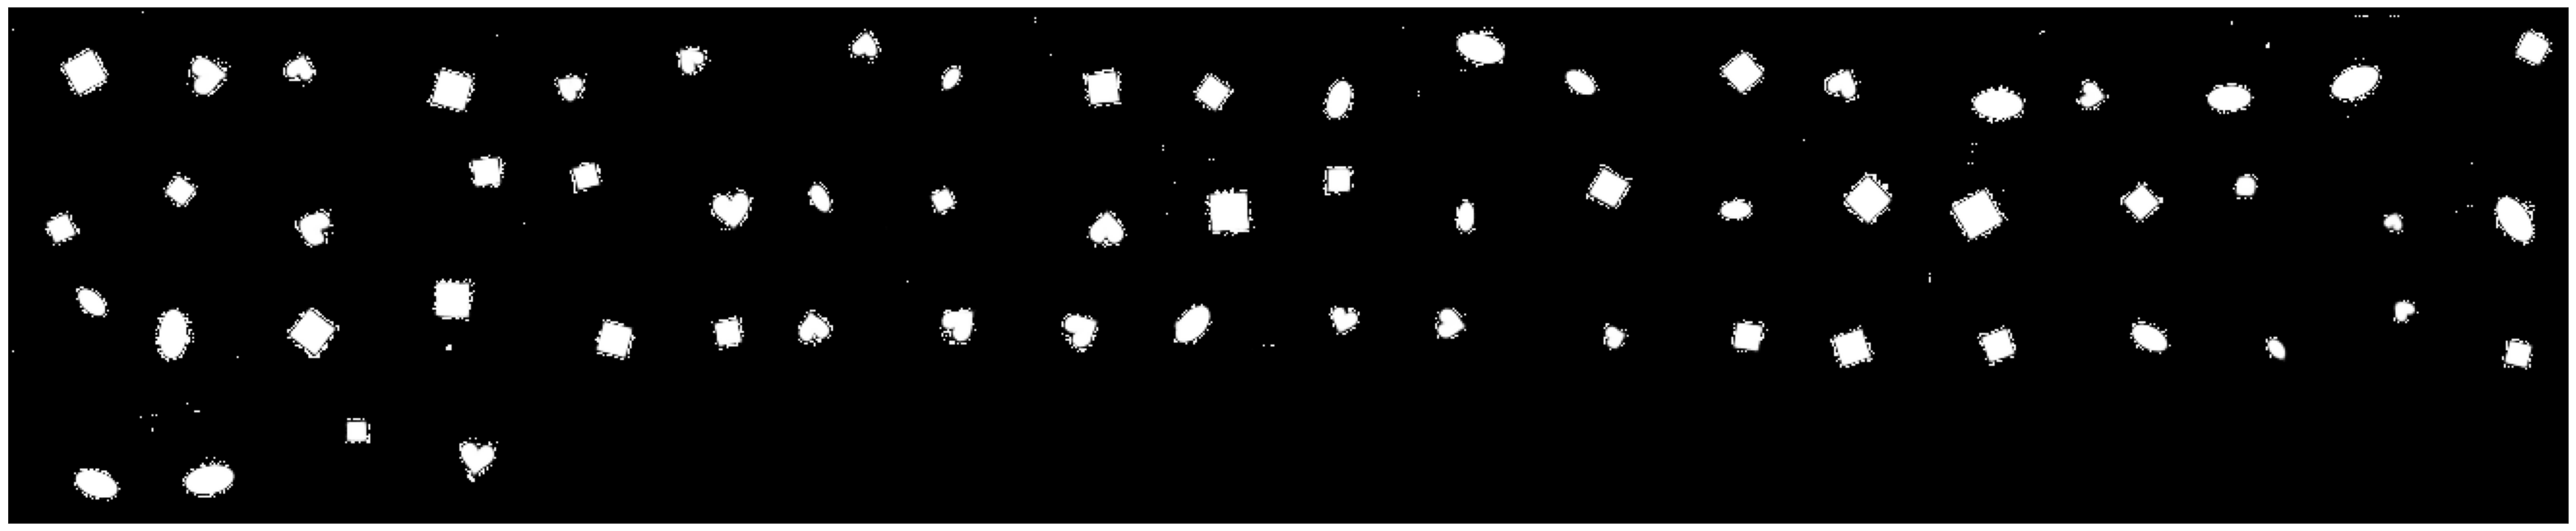

In [9]:
test_input = next(iter(test_dl))
test_input = test_input.to(device)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

grid = make_grid(recons, nrow = 20)
show(grid)

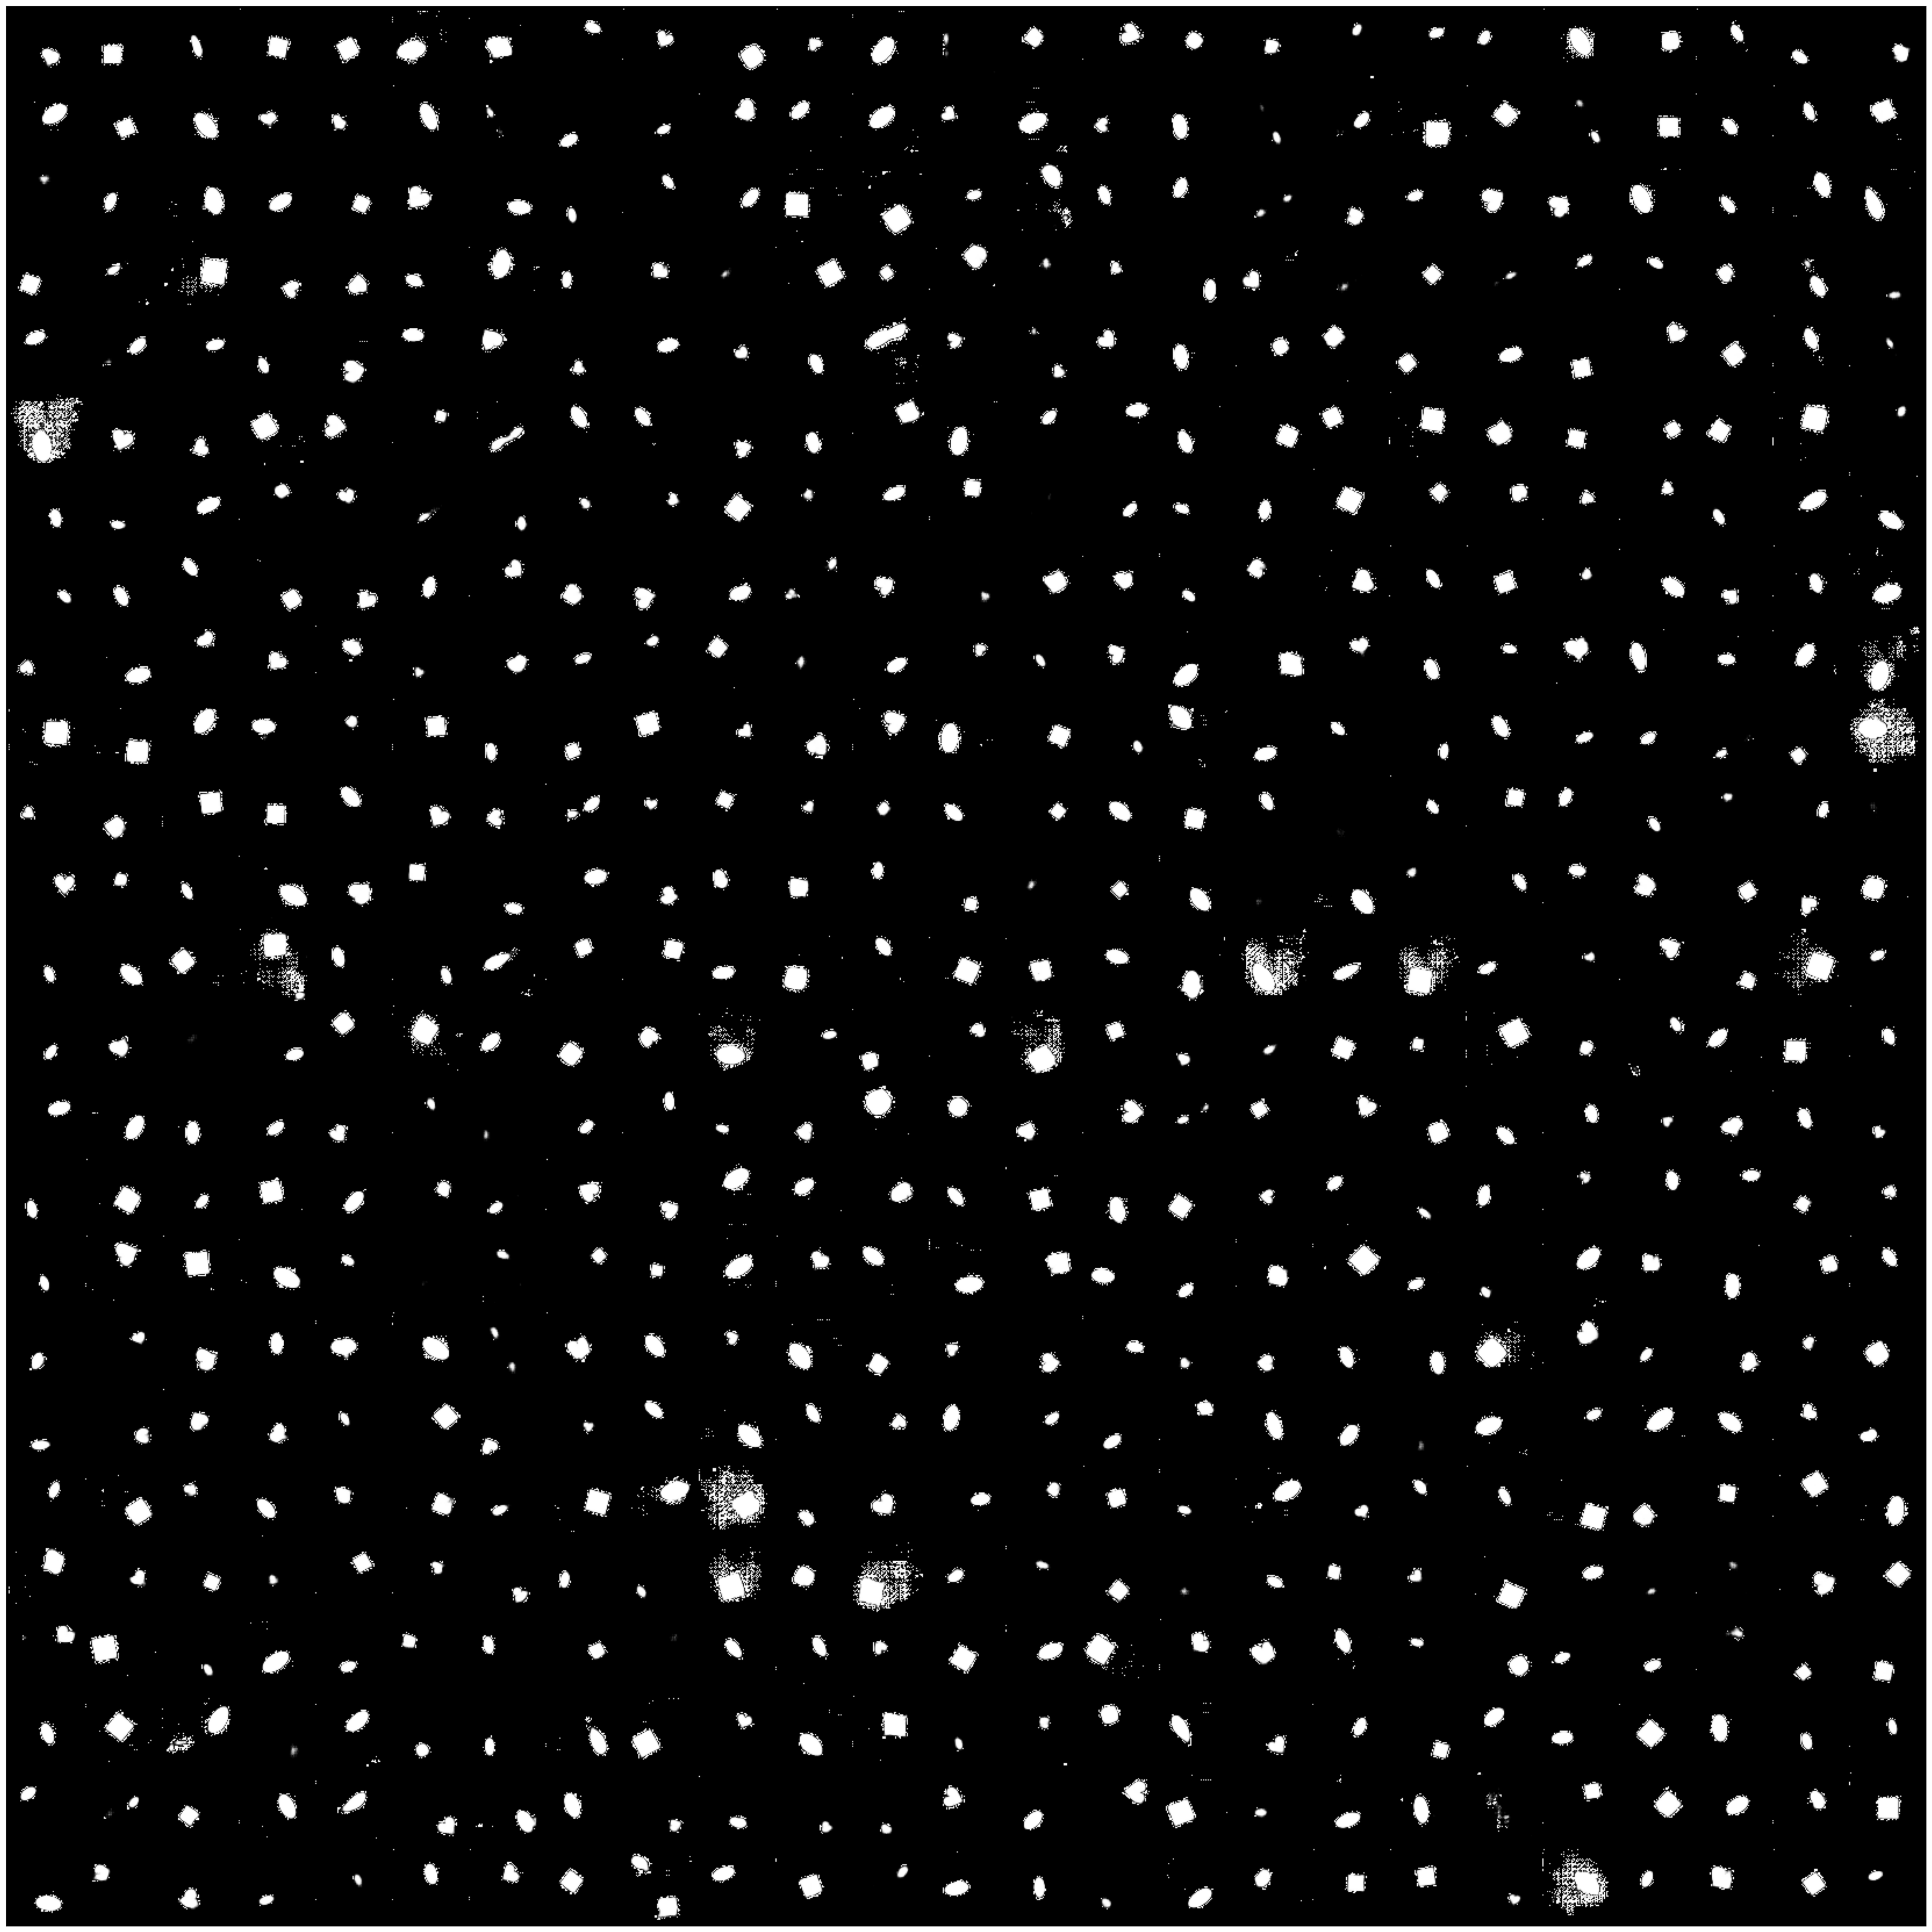

In [10]:
z = torch.randn(625, 128).to(device)

samples = model.decoder(z)

grid = make_grid(samples, nrow=25)
show(grid)